# The back-and-forth method for optimal transport

This notebook illustrates how to use the code available at https://github.com/Math-Jacobs/bfm. 

The original method is described in

* Matt Jacobs and Flavien Léger, *A fast approach to optimal transport: the back-and-forth method*, Numer. Math. **146** (2020), no. 3, 513–544, [doi:10.1007/s00211-020-01154-8](http://dx.doi.org/10.1007/s00211-020-01154-8).



In [1]:
# Run if you are on Google Colab to install the Python bindings
!git clone https://github.com/wonjunee/pybind_bfm
!pip install ./pybind_bfm

Cloning into 'pybind_bfm'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 114 (delta 48), reused 21 (delta 8), pack-reused 0
Receiving objects: 100% (114/114), 1.14 MiB | 15.73 MiB/s, done.
Resolving deltas: 100% (48/48), done.
Processing ./pybind_bfm
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for w2: filename=w2-0.0.1-cp37-cp37m-linux_x86_64.whl size=66803 sha256=172e1247b836d3b5bbe2eea091e6a4712a69e942919e0372b68faaf6f6277c6a
  Stored in directory: /tmp/pip-ephem-wheel-cache-1u_deyp1/wheels/59/df/ad/21d89dab3ad4cbb1acb68c8140bda27454aeecaa9b3f3fa06b
Successfully built w2


In [3]:
# Imports -- run once
from w2 import BFM
from time import time
import numpy as np
import numpy.ma as ma
from scipy.fftpack import dctn, idctn
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (13, 8)
plt.rcParams['image.cmap'] = 'plasma'

## Function definitions

In [4]:
# Initialize Fourier kernel
def initialize_kernel(n1, n2):
    xx, yy = np.meshgrid(np.linspace(0,np.pi,n1,False), np.linspace(0,np.pi,n2,False))
    kernel = 2*n1*n1*(1-np.cos(xx)) + 2*n2*n2*(1-np.cos(yy))
    kernel[0,0] = 1     # to avoid dividing by zero
    return kernel

# 2d DCT
def dct2(a):
    return dctn(a, norm='ortho')
    
# 2d IDCT
def idct2(a):
    return idctn(a, norm='ortho')

# Update phi as 
#       ϕ ← ϕ + σ Δ⁻¹(ρ − ν)
# and return the error 
#       ∫(−Δ)⁻¹(ρ−ν) (ρ−ν)
# Modifies phi and rho
def update_potential(phi, rho, nu, kernel, sigma):
    n1, n2 = nu.shape

    rho -= nu
    workspace = dct2(rho) / kernel
    workspace[0,0] = 0
    workspace = idct2(workspace)
    
    phi += sigma * workspace
    h1 = np.sum(workspace * rho) / (n1*n2)
    
    return h1

# Compute the dual value
# 
#       ∫ (½|x|² − ϕ(x)) ν(x)dx  +  ∫ (½|x|² − ψ(x)) μ(x)dx 
# 
def compute_w2(phi, psi, mu, nu, x, y):
    n1, n2 = mu.shape
    return np.sum(0.5 * (x*x+y*y) * (mu + nu) - nu*phi - mu*psi)/(n1*n2)

# Parameters for Armijo-Goldstein
scaleDown = 0.95
scaleUp   = 1/scaleDown
upper = 0.75
lower = 0.25
# Armijo-Goldstein
def stepsize_update(sigma, value, oldValue, gradSq):
    diff = value - oldValue

    if diff > gradSq * sigma * upper:
        return sigma * scaleUp
    elif diff < gradSq * sigma * lower:
        return sigma * scaleDown
    return sigma


# Back-and-forth solver
def compute_ot(phi, psi, bf, sigma):

    kernel = initialize_kernel(n1, n2)
    rho = np.copy(mu)

    oldValue = compute_w2(phi, psi, mu, nu, x, y)

    for k in range(numIters+1):
          
        gradSq = update_potential(phi, rho, nu, kernel, sigma)

        bf.ctransform(psi, phi)
        bf.ctransform(phi, psi)

        value = compute_w2(phi, psi, mu, nu, x, y);
        sigma = stepsize_update(sigma, value, oldValue, gradSq)
        oldValue = value;

        bf.pushforward(rho, phi, nu);

        gradSq = update_potential(psi, rho, mu, kernel, sigma)

        bf.ctransform(phi, psi)
        bf.ctransform(psi, phi)

        bf.pushforward(rho, psi, mu)

        value = compute_w2(phi, psi, mu, nu, x, y)
        sigma = stepsize_update(sigma, value, oldValue, gradSq)
        oldValue = value

        if k % 5 == 0:
            print(f'iter {k:5d},   W2 value: {value:.6e},   H1 err: {gradSq:.2e}')


# Example: computing Caffarelli's counterexample

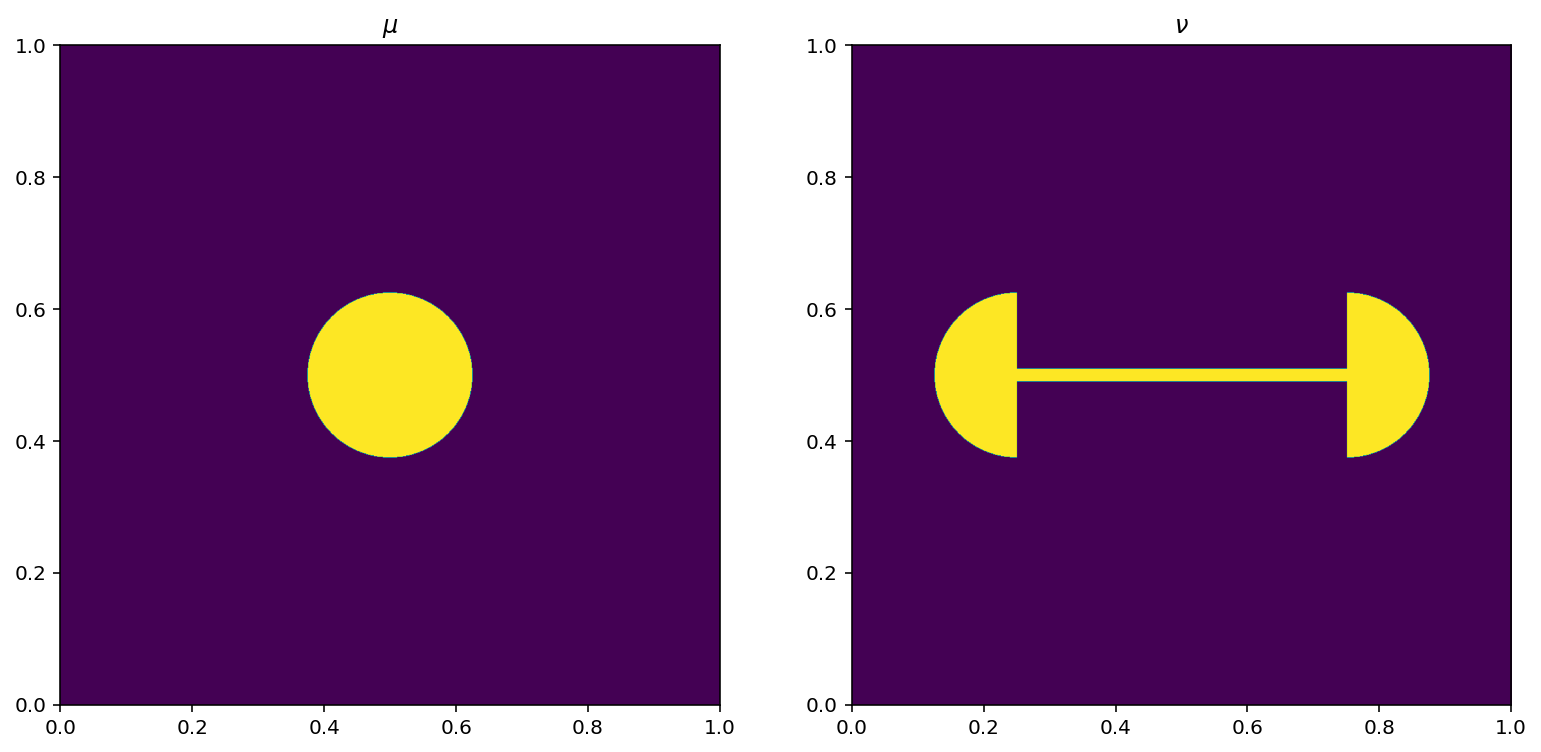

In [10]:
# Grid of size n1 x n2
n1 = 1024   # x axis
n2 = 1024   # y axis

x, y = np.meshgrid(np.linspace(0.5/n1,1-0.5/n1,n1), np.linspace(0.5/n2,1-0.5/n1,n2))


phi = 0.5 * (x*x + y*y)
psi = 0.5 * (x*x + y*y)


# Initialize densities
mu = np.zeros((n2, n1))
r = 0.125
mu[(x-0.5)**2 + (y-0.5)**2 < r**2] = 1
nu = np.zeros((n2, n1))
idx = (((x-0.25)**2 + (y-0.5)**2 < r**2) & (x < 0.25) ) 
idx = idx | (((x-0.75)**2 + (y-0.5)**2 < r**2) & (x > 0.75))
idx = idx | ((x < 0.751) & (x > 0.249) & (y < 0.51) & (y > 0.49))
nu[idx] = 1

# Normalize
mu *= n1*n2 / np.sum(mu)
nu *= n1*n2 / np.sum(nu)


# Plot mu and nu
fig, ax = plt.subplots(1, 2)
ax[0].imshow(mu, origin='lower', extent=(0,1,0,1), cmap='viridis')
ax[0].set_title("$\\mu$")
ax[1].imshow(nu, origin='lower', extent=(0,1,0,1), cmap='viridis')
ax[1].set_title("$\\nu$");

# Run the back-and-forth solver

In [11]:
# Number of iterations for BFM
numIters = 50

# Initial step size
sigma = 4/np.maximum(mu.max(), nu.max())

tic = time()

# Initialize BFM method
bf = BFM(n1, n2, mu)
compute_ot(phi, psi, bf, sigma)

toc = time()
print(f'\nElapsed time: {toc-tic:.2f}s')

iter     0,   W2 value: 2.499244e-02,   H1 err: 8.34e-02
iter     5,   W2 value: 2.588346e-02,   H1 err: 3.07e-03
iter    10,   W2 value: 2.589599e-02,   H1 err: 1.07e-03
iter    15,   W2 value: 2.593037e-02,   H1 err: 1.93e-03
iter    20,   W2 value: 2.592985e-02,   H1 err: 8.21e-04
iter    25,   W2 value: 2.594125e-02,   H1 err: 1.14e-03
iter    30,   W2 value: 2.594299e-02,   H1 err: 5.31e-04
iter    35,   W2 value: 2.594577e-02,   H1 err: 4.25e-04
iter    40,   W2 value: 2.594762e-02,   H1 err: 1.46e-04
iter    45,   W2 value: 2.594839e-02,   H1 err: 1.04e-05
iter    50,   W2 value: 2.594842e-02,   H1 err: 5.45e-07

Elapsed time: 30.52s


# Plotting the result

In [16]:
# Plotting interpolation
def plot_interpolation(mu, nu, phi, psi, n_fig=6):
    fig, ax = plt.subplots(1, n_fig, figsize=(20,8))
    [axi.axis('off') for axi in ax.ravel()]
    vmax = mu.max()
    ax[0].imshow(mu, vmax=vmax, cmap='inferno')
    ax[0].set_title("$t=0$")
    ax[n_fig-1].imshow(nu, vmax=vmax, cmap='inferno')
    ax[n_fig-1].set_title("$t=1$")

    interpolate = np.zeros_like(mu)
    rho_fwd = np.zeros_like(mu)
    rho_bwd = np.zeros_like(mu)

    for i in range(1,n_fig-1):
        t = i / (n_fig - 1)
        psi_t = (1-t) * 0.5 * (x*x + y*y) + t * psi
        phi_t = t * 0.5 * (x*x + y*y) + (1-t) * phi

        bf.pushforward(rho_fwd, psi_t, mu)
        bf.pushforward(rho_bwd, phi_t, nu)
        interpolate = (1-t) * rho_fwd + t * rho_bwd
        ax[i].imshow(interpolate, vmax=vmax, cmap='inferno')  
        ax[i].set_title(f"$t={i}/{n_fig-1}$")

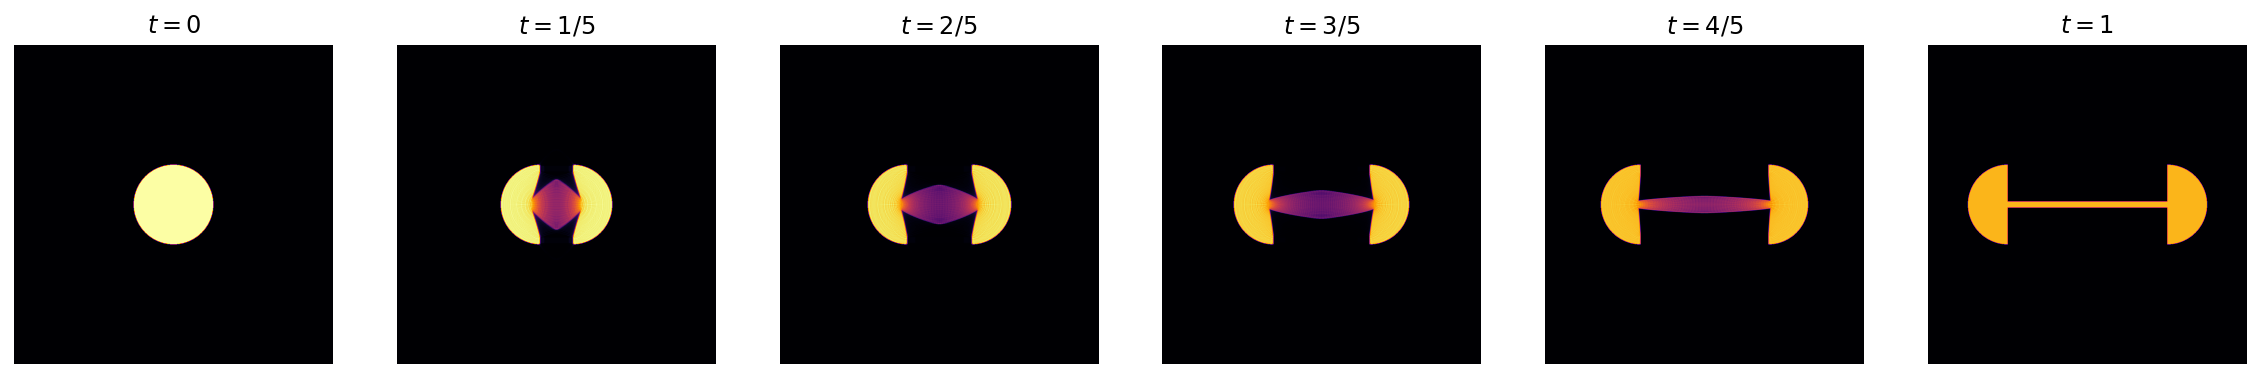

In [17]:
plot_interpolation(mu, nu, phi, psi)

Plot the optimal tranport map

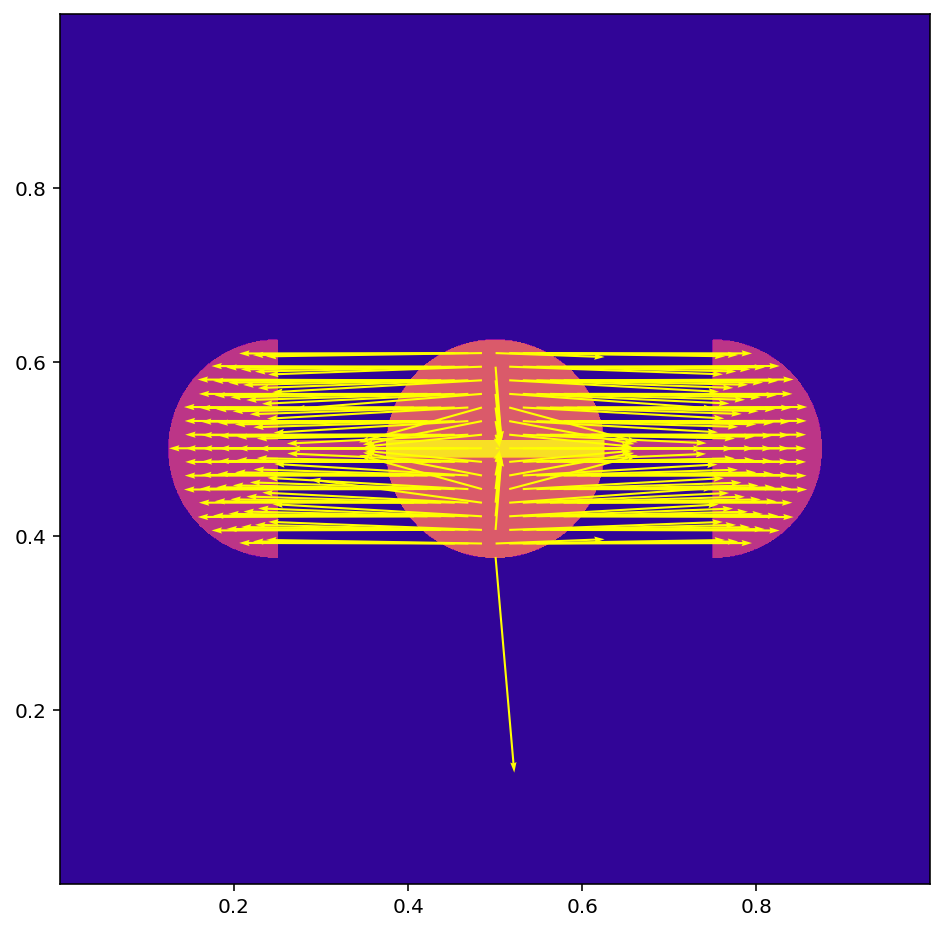

In [25]:
my, mx = ma.masked_array(np.gradient(psi-0.5*(x*x+y*y), 1/n2, 1/n1), 
    mask=((mu==0), (mu==0)))

fig, ax = plt.subplots()
ax.contourf(x,y,(mu+nu))
ax.set_aspect('equal')
skip = (slice(None,None,n1//64), slice(None,None,n2//64))
ax.quiver(x[skip], y[skip], mx[skip], my[skip], color='yellow', 
    angles='xy', scale_units='xy', scale=1);


Since the above plot is hard to read we instead display only the $x$-component of the map

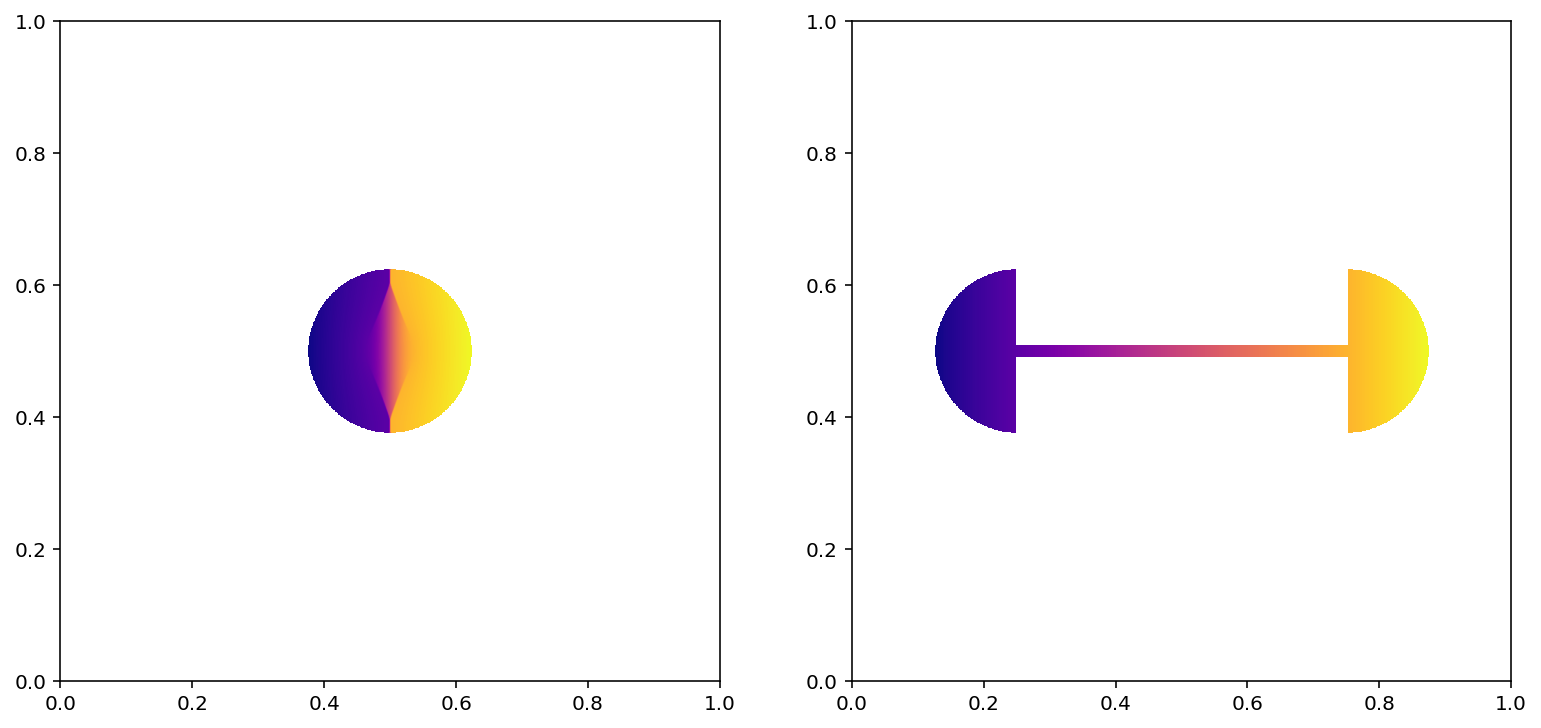

In [26]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(x + mx, origin='lower', extent=(0,1,0,1), cmap='plasma')

x_masked = ma.masked_array(x, mask=(nu==0))
ax[1].imshow(x_masked, origin='lower', extent=(0,1,0,1), cmap='plasma');